# Antenna Placement Through Particle Swarm Optimization 

The intention of this problem is to use the PSO (Particle Swarm Optimization) algorithm in a quasi-real application, highlighting a possible way to model a given problem to the PSO structure and evaluate the final response. This post has no intention to mimic a real problem, but rather to be used for motivation and curiosity. The data used was collected from public sources (http://www.rio.rj.gov.br).

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import copy
import sys
import os

sys.path.append("../../")

from Swarm import PSO
from Problems import Problem_Antenna

# Problem Definition 

The arrangement of antennas in a high populated area is crucial for the correct coverage and operation of communication systems, such as cellphones, TV broadcast and more. Considering a possible future operation of self controlled vehicles, it is interesting, if not fundamental, to have a fast and reliable communication network that ensures the correct operation of this distributed system.

The placement of the antennas must be carefull projected in order to guarantee that the total communication demand will be met, with the lower cost possible. Antennas with different coverage range and power cost differently. The biggest is the coverage radius and capacity, the costly is to buy, install and maintain the antenna. A natural trade-off between big/small antennas arises and which is not trivial to calculate.

The problem can be defined as: find the best configuration of antennas (antenna type and position along the streets) that maximizes the coverage at the lowest possible cost. The scenario is a part of the landscape of Rio de Janeiro, Brazil, where some important streets and avenues were simplified and distributed as segments in a 2D map (see figure below). Each straight line between two markers on the map represents a segment, with an approximated traffic flow (estimated from real data collected from public sources). Although the problem should consider the antenna capacity to communicate with the vehicles depending on the traffic flow, it was simplified here: the antenna capacity is unlimited. The problem considerations are:

- Each segment can only have one antenna (or none)

- Any part of the segments can be covered by any antenna if this part is inside the antenna radius

- Antennas have unlimited capacity

- The traffic flow is constant inside the segment

- The traffic flow in a given point of the segment is defined as the traffic flow in the segment divided by its length


<img src="static/pso_rio_map.png" width="800px"/>

## Data

Figure below shows the antenna cost as a function of its radius. There are 6 types of antennas, with different radius and costs. Notice that the antenna with radius 0 is a possible candidate. The algorithm difficulty in finding the best solution is somehow influenced by the relationship between these two properties, together with the map complexity.

<img src='static/pso_antenna_cost.png' />

Another important graph is the traffic flow in each segment. Segments with high traffic flow are likely to be covered by any antenna, as it is very costly to leave them without coverage. Also, it would require more than one antenna, if they do not have unlimited capacity (not the case in this problem). The figure below shows the bar plot of the flow in each segment. It can be seen that the segment "'Fonte da Saudade' to 'Reboucas'" has the highest traffic flow, while other segments like the "'Corte Cantagalo' to 'Av Atlantica - Bolivar'" has the lowest. 
<img src="static/pso_antenna_traffic_flow_bar.png" width="800px"/>

# Problem Modeling 

In total, there are 31 segments. The final solution can have up to 31 antennas, with 31 x (6+1) different configurations. The problem complexity increases because the solution must also give the position of each antenna. Each segment is modeled as a variable that needs to define which type of antenna is installed and the corresponding position inside the segment. Notice that an antenna with radius 0 is possible, which is interpreted as *no antenna*. In order to cope these two information (position and antenna type), the variable for each *i-th* segment, say $X_i$, stores the antenna type information in its integer value and the position in its decimal value, relative to the segment start. For example, the segment $X_3 = 2.45$ reads: the antenna placed in segment *3* is of type *2* (0.5 radius, cost 200) and it is positioned at 45% of the segment length. Notice that the segment possible positions for the antennas correspond to the interval [0,1). If $X_2 = 0.10$, a radius 0 antenna is placed at 10% of the segment length, meaning that no antenna is placed at all.


This modeling gives the problem a dimensionality of 31, where each dimension correspond to the variable $X_i$, which ranges from 0 to N, where N is the total number of antenna types (excluding the antenna radius 0). In our case, this range is [0, 7). Notice that there is a part of the search space that is irrelevant, as any decimal value is useless when its integer part is 0.


For the PSO modeling, each particle is a point in the 31-dimensional search space. The particles are freely to move inside the hypercube defined by the [0, 7) range. The position of each particle must be decoded into the antenna type and segment position in order to evaluate configuration cost. The cost function considers the total amount of vehicles that are covered by the antennas, excluding overlaps (more than one antenna covering the same segment). This part of the cost is defined as the Quality of Service, or QoS. The second part of the cost function is the installation/maintenance part (IM cost),  that depends solely on the types of antennas used. The final cost is then: $Cost = IM + (QoS^{max} - QoS)$, where $QoS^{max}$ is the total vehicles that should be covered by the antennas (the total traffic flow in the segments), and the optimal solution should minimize this cost function (smaller IM cost with higher QoS cost). Notice that the optimal value is not zero, as the $IM$ cost is null only if the $QoS$ value is different then the $QoS^{max}$.


The challenge is to find the lowest value of $IM$ that still makes $QoS = QoS^{max}$. In this problem, the cost of leaving some subsegments uncovered (thus some vehicles) might not be balanced with the antenna cost, leading the algorithm to always cover all subsegments. This balance depends on business rules and constraints that are out of the scope for this post.


## Implementation 

The calculation of the cost function is the most expensive part of the algorithm, as it must be calculated, without overlap, the total number of vehicles covered for each solution candidate (each particle). For that, each segment is uniformly split into *B* number of bins, forming *B*-subsegments. Each bin has *T / B* vehicles passing in an instant of time. The cost function must evaluate which subsegments are covered by the antennas, that is, which subsegments are inside the antenna radius, and then sum-up the corresponding vehicles for the covered subsegments. Each subsegment is accounted only once by doing an *OR* for all subsegments covered by all antennas.

Each subsegment has a coordinate in the xy plan of the map. With these coordinates and the position of the antenna, it is possible to measure the distance between each subsegment and the antenna. If this distance is smaller than the antenna radius, then the subsegment is covered by the antenna and its vehicles can be accounted in the QoS cost.

The calculation of which subsegments are inside the antennas coverage is implemented with Theano, in order to speed-up the algorithm.

## Remarks 

Notice that the same modeling can be used in different solutions than the PSO algorithm. It could be used, for instance, in linear programming algorithms or to build a graph model.

# Solution Testing 

## Coverage 

The figure below shows an example of segment coverage considering only three active antennas (the others are set to 0 radius). It can be seen that antennas with long radius can cover several subsegments, sometimes leaving part of a segment uncovered, which would increase the value of the cost function. It can be seen that, the more antennas with long radius are placed, the more overlap (thus operation inefficiency in this example) we have. The elliptical shape of the antennas is a illustion from the aspect ratio between the *x* and *y* dimensions on the map. Everything is calculated considering a the antenna's range as a circle. 

<img src="static/pso_antenna_coverage.png"/>

## Solve Test Data 

PSO Training started...
done (62.77 s)
	Time epochs: 62.69 s
	Time cost F: 61.86 s
	Solution found with cost:  2400.0


0

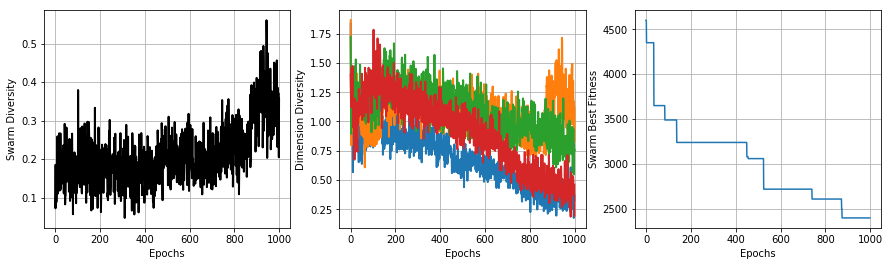

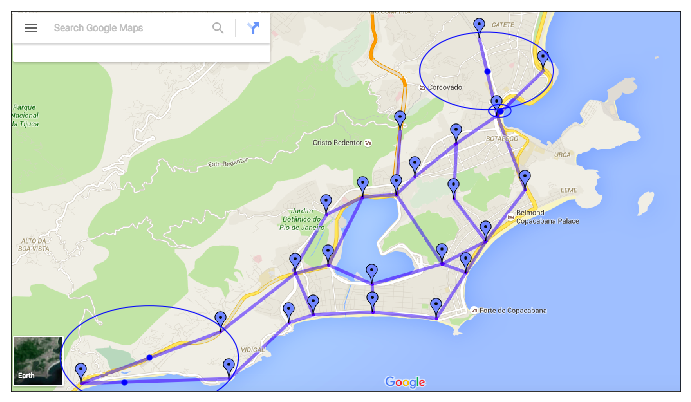

In [52]:
problem = Problem_Antenna.Problem()
problem.load_test() # for testing
swarm_dim = problem.get_problem_dim()
swarm_min, swarm_max = problem.get_solution_limits()
psoArgs = {
    'nswarm': 40,
    'swarm_dim': swarm_dim,
    'epochs': 1000,
    'chi': -1, # 0.729,
    'rate_cog': 2.05,
    'rate_soc': 2.05,
    'K': 5.0,
    'Wup': 1.8,
    'Wlo': 0.75,
    'Wstep': 800,
    'swarm_max': swarm_max,
    'swarm_min': swarm_min,
    'speed_lim': -1,
}
mypso = PSO.PSO(psoArgs)
mypso.cost_func = problem.cost_function
mypso.initialize()
(solution_idx, sol_cost) = mypso.train()
opt_solution = mypso.swarm_best[-1]
print("\tSolution found with cost: ", sol_cost)
## Plot Epoch Evolution
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mypso.global_diversity, 'k', lw=2)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Swarm Diversity')

plt.subplot(1,3,2)
plt.plot(mypso.diversity, lw=2)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Dimension Diversity')

plt.subplot(1,3,3)
plt.plot(mypso.fitness)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Swarm Best Fitness')
## SOLUTION MAP
plt.figure(figsize=(12,8))
problem.plot_map()
ax = plt.axis()
problem.plot_solution(opt_solution, 'b')
plt.axis(ax);
# GIF
problem.plot_swarm_evolution(mypso.swarm_best,50, 'test_pso_evolution.gif')
# Fix some issues on margin and border of the final gif.
os.system("convert test_pso_evolution.gif -trim +repage -border 0  test_pso_evolution.gif")

The above code creates the antenna problem, in 'test' mode, and solves it with the PSO algorithm. The PSO configuration is set to run over several iterations (*epochs*) in order to fine tune the result. We can see the evolution of the training through the *Swarm Best Fitness*. It can be seen that the algorithm finds local minima quickly, but it takes some time to find the final optimal value, around the epoch number 900. After, the algorithm was unable to find any other best solution. In fact, by inspecting the final result, on the map, it seems that that this is the best configuration, as it is needed a small antenna on the top of the map to cover a tiny part of the segments. This is less costly than putting a larger antenna on the up-most segment.


The diversity plots show that the "Swarm Diversity" (top figure) increases just around the epoch 800, exactly when the optimal value was close to be found. This indicates that the best solution before this epoch was in another point in the search space, as the other particles start movint towards this new best position, thus increasing the system variance (diversity). The Dimension Diversity shows that the "Swarm Diversity" increases mainly because of the increasing in one dimension (orange curve). This means that one segment had a very different antenna, probably with a different type, and then the particles moved along this dimension to get the best result. The final configuration found was:

<table>
    <tr style="font-weight:bold"><td>Segment</td><td>Antenna Type</td><td>Position</td></tr>
    <tr><td>1</td><td>6</td><td>52%</td></tr>
    <tr><td>2</td><td>No antenna</td><td>N/A</td></tr>
    <tr><td>3</td><td>1</td><td>89%</td></tr>
    <tr><td>4</td><td>5</td><td>40%</td></tr>
</table>

The figure below shows the evolution of the best configuration. We can see that only around the epoch 800 the smaller antenna at the bottom of the map reduces gradually to type 0 (no antenna), passing first at the antenna type 1. This effect on removing overlaps can be more difficult depending on the balance between the two costs in the objective function, as the $IM$ cost is smaller than the $QoS$ cost. Increasing the $IM$ cost, with respect to the $QoS$ cost, might make the solution start from small antennas to large ones.

<img src="static/test_pso_evolution_final.gif"/>

# Results 

## Train Configuration 

The full problem was ran in batch mode, in order to take advantage of the multicore computation (running multiple cores and threads within the notebook needs special handling). The PSO algorithm ran with the following configuration:

<table>
    <tr style="font-weight:bold"><td>Parameter</td><td>Description</td><td>Value</td></tr>
    <tr><td>nswarm</td><td>Swarm size</td><td>40</td></tr>
    <tr><td>epochs</td><td>Number of training epochs (iterations)</td><td>1000</td></tr>
    <tr><td>C1</td><td>Cognition coefficient</td><td>2.05</td></tr>
    <tr><td>C2</td><td>Social coefficient</td><td>2.05</td></tr>
    <tr><td>K</td><td>Speed limit coefficient</td><td>5</td></tr>
    <tr><td>Wup</td><td>Initial inertial weight</td><td>1.5</td></tr>
    <tr><td>Wlo</td><td>Final inertial weight</td><td>0.5</td></tr>
    <tr><td>Wstep</td><td>Number of iterations to reach the final inertial weight</td><td>900</td></tr>
    <tr><td>ninit</td><td>Number of different algorithm initialization</td><td>50</td></tr>
</table>

The paremeters were not tunned. As explained in the test part: the balance between $IM$ and $QoS$ costs can be used to accelerate the convergence in this problem. Let's leave for the algorithm to find a solution within this training configuration. 


## Algorithm Evolution 

The figure below shows the evolution of the PSO algorithm over the full problem. It can be seen that, after the epoch 400, the swarm diversity start reducing significantly, with a small bump near the epoch 500. It seems that the swarm was performing a fine tuning around some local optimal solution. It can also be seen, in the plot of diversity for each dimension, that the response for some dimensions (antennas) are already found in the beginning of the algorithm, as the diversity is very small when compared to the others.

The swarm best fitness for each epoch, a kind of convergence-like figure, shows that the swarm was constantly finding better and better solutions. If more epochs were given, the result might have been even better. As the optimal value is unknown, the only way to know the global optimal is by pushing for longer epochs. In practice, the final solution must be evaluated with respect to all the business criteria and rules involved.

<img src="static/antenna_pso_epochs.png"/>

## Best Solution

The entire optimization problem was solved in around 6 hours, where each of the 50 initializations was ran over multiple CPU cores. Although costly, the algorithm seemed to be able to find the best solution possible. In the end, it used only 11 antennas. Because of the street distribution and the antenna radiuses, 20 streets do not need an antenna at all. The final antenna configuration can be seen on the following table:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
        <th>Index</th><th>Description</th><th>AntennaType</th><th>AntennaPosition</th>
        <th>Index</th><th>Description</th><th>AntennaType</th><th>AntennaPosition</th>
    </tr>
  </thead>
  <tbody>
    <tr><th>0</th><td>Elevado das bandeiras -- Tunel Zuzu Angel</td><td>0</td><td>30%</td>
        <th>1</th><td>Elevado das bandeiras -- Niemeyer</td><td>5</td><td>57%</td></tr>
    <tr><th>2</th><td>Niemeyer -- Delfim Moreira - Fim</td><td>0</td><td></td>
        <th>3</th><td>Tunel Zuzu Angel -- Sibelius</td><td>6</td><td>99%</td></tr>
    <tr><th>4</th><td>Clube Flamengo -- Sibelius</td><td>1</td><td>31%</td>
        <th>5</th><td>Delfim Moreira - Fim -- Delfim Moreira - Barto...</td><td>0</td><td>11%</td></tr>
    <tr><th>6</th><td>Sibelius -- Delfim Moreira - Bartolemeu</td><td>0</td><td></td>
        <th>7</th><td>Delfim Moreira - Bartolemeu -- Jardim de Alah</td><td>5</td><td>66%</td></tr>
    <tr><th>8</th><td>Jardim de Alah -- Arpoador</td><td>1</td><td>96%</td>
        <th>9</th><td>Jardim de Alah -- Caicaras</td><td>0</td><td>43%</td></tr>
    <tr><th>10</th><td>Clube Flamengo -- Caicaras</td><td>0</td><td></td>
        <th>11</th><td>Arpoador -- Av Atlantica - Bolivar</td><td>6</td><td>99%</td></tr>
    <tr><th>12</th><td>Corte Cantagalo -- Av Atlantica - Bolivar</td><td>0</td><td></td>
        <th>13</th><td>Clube Flamengo -- Piraque</td><td>0</td><td>86%</td></tr>
    <tr><th>14</th><td>Pacheco Leao -- Piraque</td><td>0</td><td></td>
        <th>15</th><td>Caicaras -- Corte Cantagalo</td><td>3</td><td>57%</td></tr>
    <tr><th>16</th><td>Sibelius -- Pacheco Leao</td><td>0</td><td>52%</td>
        <th>17</th><td>Piraque -- Fonte da Saudade</td><td>0</td><td>15%</td></tr>
    <tr><th>18</th><td>Corte Cantagalo -- Fonte da Saudade</td><td>0</td><td>69%</td>
        <th>19</th><td>Corte Cantagalo -- Av Atlantica - Fiqueiredo</td><td>0</td><td>37%</td></tr>
    <tr><th>20</th><td>Av Atlantica - Bolivar -- Av Atlantica - Fique...</td><td>0</td><td></td>
        <th>21</th><td>Fonte da Saudade -- Humaita</td><td>6</td><td>99%</td></tr>
    <tr><th>22</th><td>Fonte da Saudade -- Reboucas</td><td>0</td><td>16%</td>
        <th>23</th><td>Humaita -- Botafogo - Real Grandeza</td><td>3</td><td>67%</td></tr>
    <tr><th>24</th><td>Tunel Velho -- Botafogo - Real Grandeza</td><td>0</td><td></td>
        <th>25</th><td>Av Atlantica - Fiqueiredo -- Tunel Velho</td><td>0</td><td>93%</td></tr>
    <tr><th>26</th><td>Av Atlantica - Fiqueiredo -- Tunel Novo</td><td>6</td><td>99%</td>
        <th>27</th><td>Botafogo - Real Grandeza -- Praia Botafogo</td><td>0</td><td>0%</td></tr>
    <tr><th>28</th><td>Tunel Novo -- Praia Botafogo</td><td>0</td><td></td>
        <th>29</th><td>Praia Botafogo -- Aterro - Inicio</td><td>5</td><td>42%</td></tr>
    <tr><th>30</th><td>Praia Botafogo -- Tunel Sta Barbara</td><td>0</td><td>74%</td>
  </tbody>
</table>


With this configuration, the number of antenna types used shows that the solution needed, in most of the segments, the antennas with longer radius. The other antennas with smaller radius, probably, are used to cover segments that did not fit in the longer antennas, avoiding that any parts of the segments remained uncovered. If the balance between the $QoS$ cost and the $IM$ cost was different, the algorithm might have prefered to leave these subsegments uncovered.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;"><th>Type</th><th>#Antenna</th></tr>
  </thead>
  <tbody>
    <tr><td>Type 1</td><td>2</td></tr>
    <tr><td>Type 2</td><td>0</td></tr>
    <tr><td>Type 3</td><td>2</td></tr>
    <tr><td>Type 4</td><td>0</td></tr>
    <tr><td>Type 5</td><td>3</td></tr>
    <tr><td>Type 6</td><td>4</td></tr>
  </tbody>
</table>

The configuration of the antennas on the map can be seen in the next figure. As expected, most of the antennas with small radius are used to cover the spaces left by the longer ones. And it can be seen that the algorithm tried to reduce the overlap between antennas as maximum as possible.

<img src="static/antenna_pso_map_final.png"/>


## Solution Evolution 

Finally, the best solution evolution can be seen on the animation below. It can be seen that the antennas with longer radius are the first to be found and kept through every epoch, while the other ones have their radius shrunk as the swarm evolves.

<img src="static/antenna_pso_evolution_final.gif"/>

# Final Remarks 

This post showed a practical optimization problem solved by the PSO algorithm. The same modeling might be used by other optmization tools, like linear programming and graph optimization. The only difference is that it requires that the objective function should be calculated at all possible values for each segment. After calculation, the algorithms should be able to find the combination that best solves the problem. The same problem will be solved by other algorithms in future posts. It can be seen that the PSO algorithm was able to find a suitable solution in a limited, but costly time. 